# ***Missing and spurious interactions and the reconstruction of complex networks***

| Nome              |  Matricola |
|-------------------|----------|
| Eugenia Boccanera | 2109310  | 
| Lucrezia Rossi    | 2122164  |


In this notebook, we implemented a framework for assessing the reliability of network data and reconstructing complex networks, following the approach proposed in the paper *"Missing and spurious interactions and the reconstruction of complex networks"* by Guimerà and Sales-Pardo (2009).

In [2]:
import numpy as np 
import random 
import matplotlib.pyplot as plt 
import networkx as nx
import math
from itertools import combinations
import seaborn as sns

## 1 Initialize the Network

### 1.1 Load and modify the Network

This cell loads the weighted adjacency matrix from the file `fc.txt` and constructs the binary adjacency matrix `A_true` for the true network.  
For each pair of nodes, an edge is created if the corresponding weight in the matrix exceeds a fixed threshold.  
The resulting binary adjacency matrix is printed and will be used as the ground truth network for subsequent analysis.

In [3]:
# Load the weighted adjacency matrix (e.g., from fc.txt)
fc = np.loadtxt('fc.txt')

# Initialize the adjacency matrix A_true (size n x n) with zeros
n = fc.shape[0]
A_true = np.zeros((n, n))

# For each pair of nodes (i, j), create a connection if the probability exceeds the threshold
for i in range(n):
    for j in range(n):
        prob = fc[i, j]
        threshold = 0.3
        if prob >= threshold:
            A_true[i, j] = 1  # Connect nodes i and j

# Print the adjacency matrix
print(A_true)

[[1. 0. 0. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


This cell visualizes the weighted adjacency matrix loaded from `fc.txt` as a heatmap.  
Each cell in the heatmap represents the weight of the connection between node *i* and node *j*.  
This visualization helps to quickly identify patterns, clusters, or strong/weak connections in the original network data.

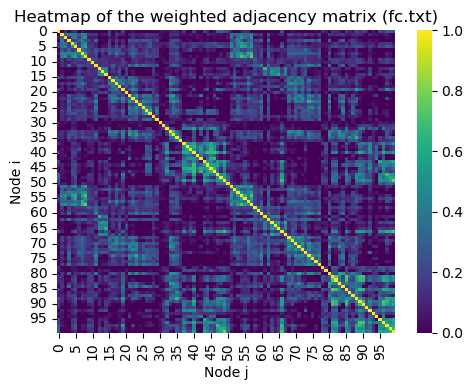

In [ ]:
# === Heatmap of the adjacency matrix ===
plt.figure(figsize=(5, 4))
sns.heatmap(fc, cmap='viridis')
plt.title('Heatmap of the weighted adjacency matrix (fc.txt)')
plt.xlabel('Node j')
plt.ylabel('Node i')
plt.tight_layout()
plt.show()

The heatmap of the weighted adjacency matrix fc shows a strong diagonal structure, indicating that the largest connection weights are concentrated along the diagonal. This suggests that nodes are most strongly connected to themselves or to nearby nodes, which may reflect a modular or clustered organization in the underlying network.

In [4]:
# Create the true network graph from the binary adjacency matrix A_true
G_true = nx.from_numpy_array(A_true)

# Print the number of nodes and edges in the true network
print(f"Number of nodes: {G_true.number_of_nodes()}")
print(f"Number of links: {G_true.number_of_edges()}")

Number of nodes: 100
Number of links: 805


We now create a function that randomly modifies a given network by removing and adding a fraction of its edges.  
- It first removes a specified fraction of existing edges, chosen at random.
- Then, it adds the same number of new edges between randomly selected pairs of nodes that are not already connected.
- The function returns the modified network, along with lists of the removed and added edges.

This process simulates noise or errors in network observation, allowing the creation of an "observed" network that differs from the true underlying structure.

In [5]:
def modify_network(G, modification_fraction):
    """
    Randomly removes and adds a fraction of edges in the network G.
    
    :param G: The input graph (NetworkX object).
    :param modification_fraction: Fraction of edges to modify.
    :return: Modified graph, list of removed edges, list of added edges.
    """
    G_modified = G.copy()
    edges = list(G.edges())
    nodes = list(G.nodes())
    num_to_modify = int(len(edges) * modification_fraction)
    
    removed_edges = []
    added_edges = []
    
    # Randomly remove edges
    edges_to_remove = np.random.choice(len(edges), num_to_modify // 2, replace=False)
    for idx in edges_to_remove:
        removed_edges.append(edges[idx])
        G_modified.remove_edge(*edges[idx])
    
    # Randomly add edges
    for _ in range(num_to_modify // 2):
        u, v = np.random.choice(nodes, 2, replace=False)
        if not G_modified.has_edge(u, v):
            G_modified.add_edge(u, v)
            added_edges.append((u, v))
    
    return G_modified, removed_edges, added_edges

In [6]:
# Create an observed network by randomly modifying the true graph
modification_fraction = 0.3 # For example, modify 30% of the connections
G_obs, removed_edges, added_edges = modify_network(G_true, modification_fraction)


# Print the number of nodes and edges in the true network
print(f"Number of nodes: {G_obs.number_of_nodes()}")
print(f"Number of links: {G_obs.number_of_edges()}")

Number of nodes: 100
Number of links: 792


Then, we group all the functions responsible for visualizing network structures. These functions generate plots to represent graphs and highlight modifications.

In [8]:
# Plots
def plot_graph(G, title):
    """
    Plots the given graph with node colors based on their block assignment.

    :param G: NetworkX graph object.
    """
    pos = nx.spring_layout(G, k=0.8, seed=42)  # Adjust 'k' to control node spacing
    plt.figure(figsize=(12, 8))  # Increase figure size for better visibility
    nx.draw(
        G, 
        pos, 
        with_labels=True, 
        edge_color='darkgrey', 
        node_color='skyblue', 
        node_size=300,  # Increase node size
        width=1.5,  # Increase edge width
        font_size=10, 
        font_color='black'
    )
    plt.title(title)
    plt.show()

def plot_modified_network(G, removed_edges, added_edges, title):
    """
    Plots the observed network with highlighted removals and additions.

    :param G: NetworkX graph object.
    :param removed_edges: List of edges removed from the original graph.
    :param added_edges: List of edges added to the original graph.
    :param title: Title of the plot.
    """
    pos = nx.spring_layout(G, k=0.5, seed=42)  # Adjust 'k' to control node spacing
    
    plt.figure(figsize=(12, 8))  # Increase figure size for better visibility
    nx.draw(
        G, 
        pos, 
        with_labels=True, 
        node_color='skyblue', 
        edge_color='gray', 
        node_size=300,  # Increase node size
        width=1.5,  # Increase edge width
        font_size=10, 
        font_color='black'
    )
    # Highlight removed edges in red (dashed)
    nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color='red', style='dashed', width=1)
    # Highlight added edges in green (solid)
    nx.draw_networkx_edges(G, pos, edgelist=added_edges, edge_color='green', style='solid', width=1)
    
    plt.title(title)
    plt.show()
    


def plot_H_trace(H_burn_in, H_full_trace):
    """
    Plots the full trace of H(P), including the burn-in phase and sampling.

    :param H_burn_in: List of H(P) values during the burn-in phase.
    :param H_full_trace: List of H(P) values during the full MCMC sampling.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(H_burn_in)), H_burn_in, marker=',', linestyle='-', linewidth=0.5, label="Burn-in")
    plt.plot(range(len(H_burn_in), len(H_burn_in) + len(H_full_trace)), H_full_trace, marker=',', linestyle='-', linewidth=0.5, label="Sampling")
    plt.axvline(x=len(H_burn_in), color='r', linestyle='--', linewidth=1, label="End of burn-in")
    plt.xlabel("Iterations")
    plt.ylabel("H(P)")
    plt.title("Full Trace of H(P) Without Thinning")
    plt.legend()
    plt.show()


def plot_final_H_trace(H_final, thinning_interval):
    """
    Plots the final trace of H(P) after applying thinning.

    :param H_final: List of H(P) values after thinning.
    :param thinning_interval: Interval used for thinning.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(H_final)), H_final, marker='o', linestyle='-')
    plt.xlabel(f'Sampling iterations with thinning every {thinning_interval}')
    plt.ylabel('H(P)')
    plt.title('Final Trace of H(P) After Thinning')
    plt.show()


def plot_interaction_accuracies(error_fractions, accuracy_missing, accuracy_spurious):
    """
    Plots the accuracy for Missing and Spurious Interactions.

    :param error_fractions: List of error fractions.
    :param accuracy_missing: Accuracy values for missing interactions.
    :param accuracy_spurious: Accuracy values for spurious interactions.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot for Missing Interactions
    ax1.plot(error_fractions, accuracy_missing, 'ko-', markersize=8, label='Missing interactions')
    ax1.set_xlabel('Fraction of removed links (f)')
    ax1.set_ylabel('Accuracy (probability)')
    ax1.set_title('Missing Interactions')
    ax1.legend()
    ax1.grid(True)

    # Plot for Spurious Interactions
    ax2.plot(error_fractions, accuracy_spurious, 'ko-', markersize=8, label='Spurious interactions')
    ax2.set_xlabel('Fraction of added links (f)')
    ax2.set_ylabel('Accuracy (probability)')
    ax2.set_title('Spurious Interactions')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


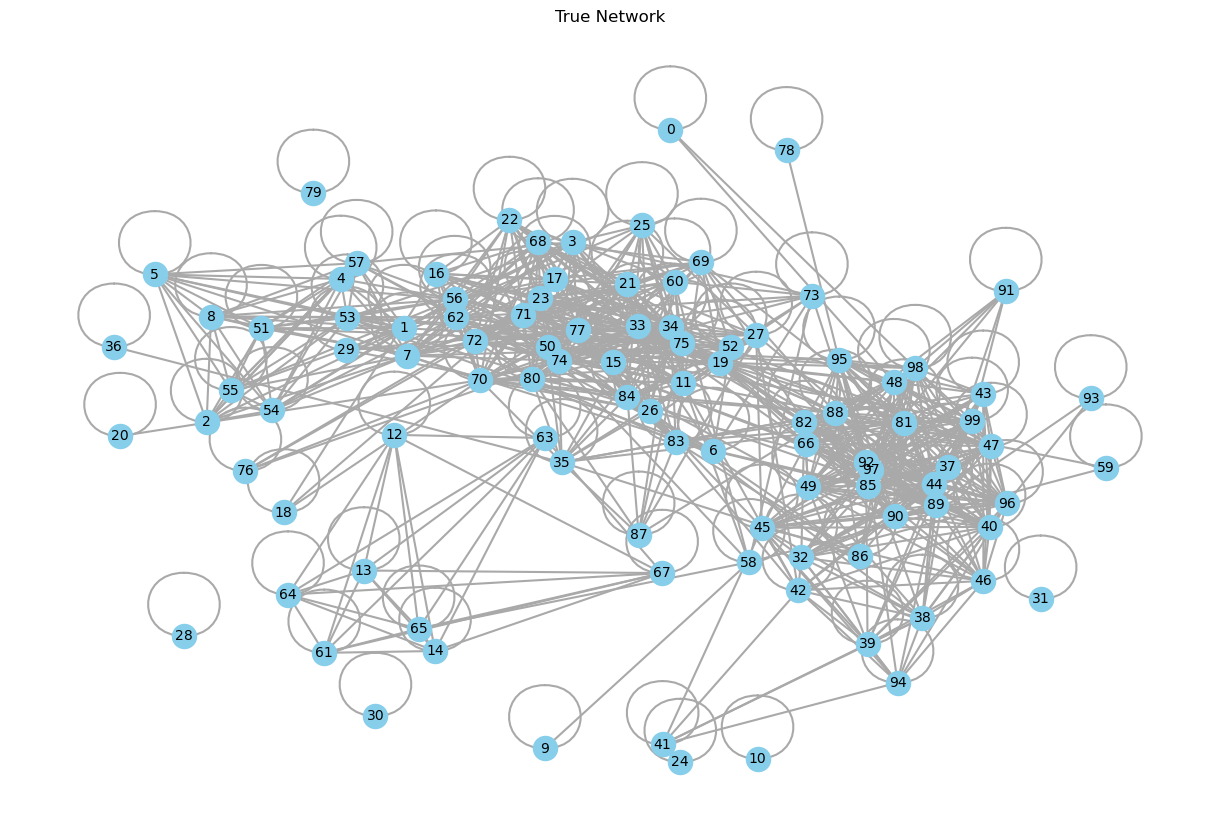

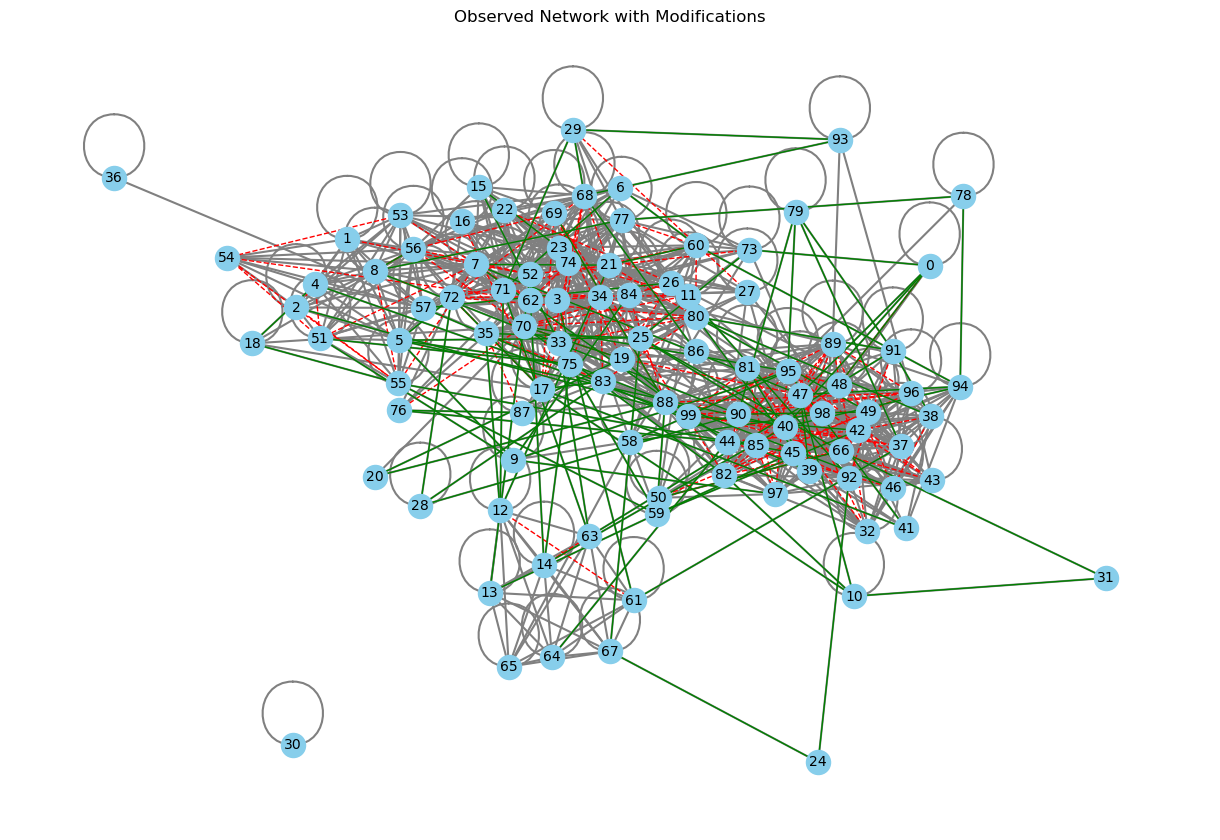

In [9]:
# Plot the true network
plot_graph(G_true, "True Network")

# Plot the observed network
plot_modified_network(G_obs, removed_edges, added_edges, "Observed Network with Modifications")

### 1.2 Computing Entropy in Network Partitions

In this cell we define two key functions for entropy-based analysis of network partitions:

- `initialize_partition(G)`: Randomly assigns each node in the graph `G` to a group, creating an initial partition. Each node can be assigned to any group, allowing for a diverse starting configuration for further sampling.

- `calculate_H(P, G)`: Computes the entropy \( H(P) \) of a given partition \( P \) for the graph \( G \). The function:
  - Groups nodes according to their assigned blocks.
  - Counts the observed links between and within these blocks.
  - Calculates the maximum possible number of links for each block pair.
  - Uses a combinatorial formula to compute the entropy, reflecting the uncertainty or complexity of the partition.

This entropy measure is central to the stochastic block model approach, quantifying how well a given partition explains the observed network structure.

In [10]:
def initialize_partition(G):
    """Initialize random partitions (each node is its own group)."""
    num_nodes = len(G.nodes())
    return {node: random.choice(range(num_nodes)) for node in G.nodes()}  # Randomly assign each node to a group


def calculate_H(P, G):
    """Calculates H(P) for a given partition P and graph G."""
    # Group nodes by block
    block_nodes = {}
    for node, group in P.items():
        block_nodes.setdefault(group, []).append(node)

    lO = {}  # Observed links between blocks
    r = {}   # Possible links between blocks
    
    # Count links in the observed network
    for u, v in G.edges():
        gu, gv = P[u], P[v]
        key = tuple(sorted([gu, gv]))
        lO[key] = lO.get(key, 0) + 1
    
    # Compute rαβ (maximum possible links between groups)
    groups = list(block_nodes.keys())
    for g in groups:
        n = len(block_nodes[g])
        r[(g, g)] = n * (n - 1) // 2  # Combinations of 2
    # Pairs of different groups
    for g1, g2 in combinations(groups, 2):
        r[tuple(sorted([g1, g2]))] = len(block_nodes[g1]) * len(block_nodes[g2])
    
    # Compute H(P)
    H = 0.0
    for key in r:
        # Note: We add 1 to the denominator as per the formula and use log(comb) for the combinatorial term.
        H += math.log(r[key] + 1)
        # To avoid log(0) or errors, we use 0 if no observed links exist
        links = lO.get(key, 0)
        try:
            comb_value = math.comb(r[key], links) if r[key] >= links else 1
        except ValueError:
            comb_value = 1
        # For safety, if comb_value results in 0, we add a small epsilon
        H += math.log(comb_value)
    
    return H

### 1.3 MCMC Sampling for Network Partitions

The following functions define the Metropolis-Hastings acceptance criterion and the MCMC sampling function for network partitions:

- `metropolis_acceptance`: Implements the Metropolis acceptance rule, which decides whether to accept a proposed change in the partition based on the change in entropy (\( \Delta H \)). Moves that decrease entropy are always accepted, while moves that increase entropy are accepted with a probability proportional to \( \exp(-\Delta H) \).

- `mcmc_trace_H`: Performs Markov Chain Monte Carlo (MCMC) sampling on the network partitions. The function first runs a burn-in phase to allow the Markov chain to reach equilibrium, storing the entropy values at each step. After burn-in, it samples partitions and records the entropy trace for further analysis. This process enables the exploration of the space of possible partitions according to their entropy, which is central to the stochastic block model approach.

In [11]:
def metropolis_acceptance(delta_H):
    """Decides whether to accept a new state based on the Metropolis criterion."""
    return delta_H <= 0 or np.random.rand() < np.exp(-delta_H)


def mcmc_trace_H(G, equilibration, num_samples):
    """
    Performs MCMC sampling, collecting all H(P) values without thinning.

    :param G: NetworkX graph for sampling.
    :param equilibration: Number of burn-in iterations.
    :param num_samples: Total number of sampling iterations.
    :return: List of sampled partitions, H values during sampling, and full trace of H values.
    """
    num_nodes = len(G.nodes())
    P = initialize_partition(G)
    
    # Store H(P) values during burn-in
    H_burn_in = []
    for i in range(equilibration):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        old_H = calculate_H(P, G)
        new_group = random.choice(range(num_nodes))
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        if not metropolis_acceptance(delta_H):
            P[node] = old_group
        H_burn_in.append(calculate_H(P, G))  # Store all H(P) values in burn-in
    
    # Sampling phase without thinning
    partitions = []
    H_full_trace = []  # Stores all H(P) values during sampling without thinning
    for i in range(num_samples):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        old_H = calculate_H(P, G)
        new_group = random.choice(range(num_nodes))
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        if not metropolis_acceptance(delta_H):
            P[node] = old_group
        partitions.append(P.copy())
        H_full_trace.append(calculate_H(P, G))  # Records all H(P) values without thinning
    
    return partitions, H_burn_in, H_full_trace


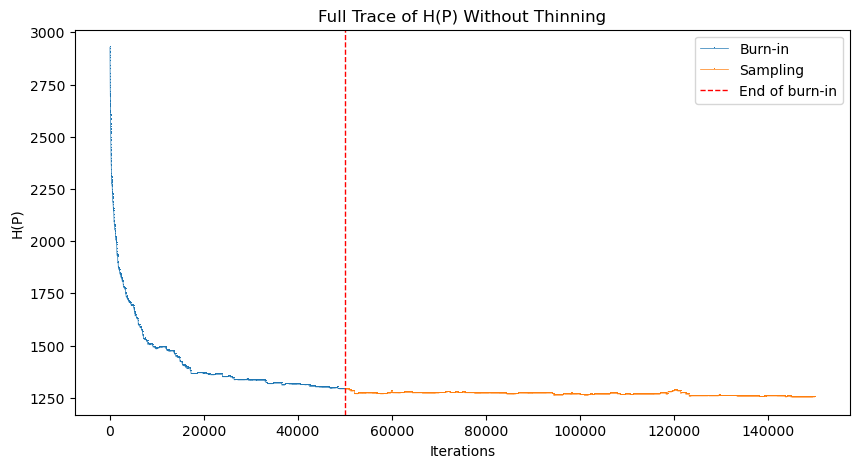

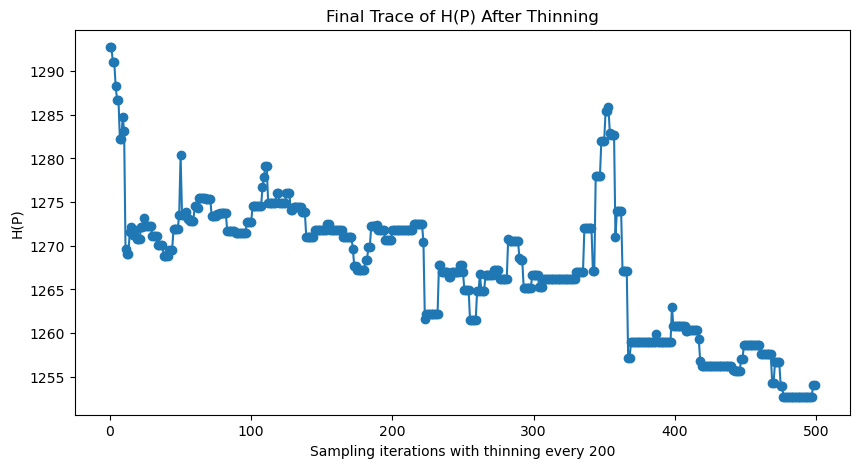

In [ ]:
# Perform MCMC sampling on the observed network partitions, collecting the trace of H(P)
partitions, H_burn_in, H_full_trace = mcmc_trace_H(G_obs, equilibration=50000, num_samples=100000)

# Plot the H(P) trace
plot_H_trace(H_burn_in, H_full_trace)   

thinning_interval = 200

# Apply thinning to H(P) samples
H_final = H_full_trace[::thinning_interval]
# Apply thinning to partitions to obtain independent samples
partitions_thinned = partitions[::thinning_interval]

# Call the function to plot the final trace of H(P)
plot_final_H_trace(H_final, thinning_interval)                ### CANCEL??

C:\Users\eugen\AppData\Local\Temp\ipykernel_11064\2453020964.py:22: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(1, max_lag + 1), autocorr_values, use_line_collection=True)


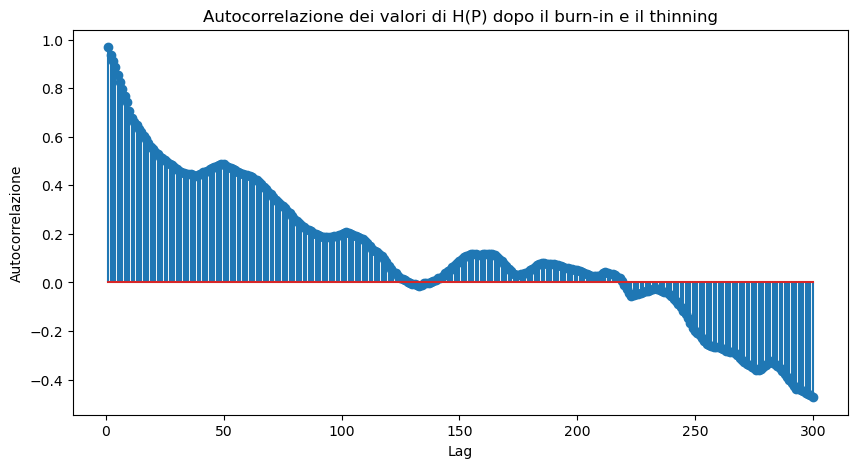

In [13]:
##### Poi questo lo TOGLIAMO, è solo per vedere come va l'autocorrelazione 

def autocorrelation(series, max_lag):
    """ Calcola l'autocorrelazione per una serie di valori fino a max_lag. """
    n = len(series)
    mean = np.mean(series)
    c0 = np.sum((series - mean) ** 2) / n
    autocorrs = []

    for lag in range(1, max_lag + 1):
        ct = np.sum((series[:n - lag] - mean) * (series[lag:] - mean)) / (n - lag)
        autocorrs.append(ct / c0)

    return autocorrs

# Calcoliamo l'autocorrelazione per i valori di H(P) del burn-in
max_lag = 300  # Puoi variare questo valore per vedere fino a dove l'autocorrelazione decade
autocorr_values = autocorrelation(H_final, max_lag)

# Plottiamo la funzione di autocorrelazione
plt.figure(figsize=(10, 5))
plt.stem(range(1, max_lag + 1), autocorr_values, use_line_collection=True)
plt.xlabel("Lag")
plt.ylabel("Autocorrelazione")
plt.title("Autocorrelazione dei valori di H(P) dopo il burn-in e il thinning")
plt.show()


## 2 Compute the reliabilities

### 2.1 Link Reliability

This section introduces the function `estimate_link_reliability`, which calculates the link reliability $RL_{ij}$ for each node pair $(i,j)$ in a network, following a probabilistic formulation.

- The function iterates over a set of sampled partitions and computes the probability of a link existing between nodes, based on observed and expected connections.

- It uses the entropy function $H(P)$ to weigh partitions, ensuring statistically significant estimates.

- The result provides a normalized reliability score, which helps infer missing or uncertain links in noisy network data.


In [14]:
def estimate_link_reliability(G, partitions, H_values):
    """
    Estimates link reliability RL_ij for each pair (i, j) where i < j,
    using the formula:
    
    RL_ij = (1/Z) * sum_{P in partitions} [ (lO_{σ_iσ_j}+1)/(r_{σ_iσ_j}+2) * exp(-H(P) ) ]
    """
    # Initialize dictionary for RL for all pairs (i, j)
    nodes = list(G.nodes())
    reliability = {}
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            reliability[(i, j)] = 0.0

    # Find the maximum H(P) value to compute c
    c = max(H_values)
    
    Z = 0.0  # Normalization factor
    
    for P, H_P in zip(partitions, H_values):
        weight = np.exp(-H_P + c)  # Adjusted weight with normalization constant c
        Z += weight
        
        # Group nodes by block for partition P
        block_nodes = {}
        for node, group in P.items():
            block_nodes.setdefault(group, []).append(node)
        
        # Precompute r and lO for each pair of blocks in partition P
        r = {}
        lO = {}
        groups = list(block_nodes.keys())
        # For identical blocks
        for g in groups:
            n = len(block_nodes[g])
            r[(g, g)] = n * (n - 1) // 2
            # Count observed links within the block
            count = 0
            for u, v in combinations(block_nodes[g], 2):
                if G.has_edge(u, v):
                    count += 1
            lO[(g, g)] = count
        # For different block pairs
        for g1, g2 in combinations(groups, 2):
            key = tuple(sorted([g1, g2]))
            r[key] = len(block_nodes[g1]) * len(block_nodes[g2])
            count = 0
            for u in block_nodes[g1]:
                for v in block_nodes[g2]:
                    if G.has_edge(u, v):
                        count += 1
            lO[key] = count
        
        # Apply formula for each node pair (i, j) based on groups in P
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                g_i = P[nodes[i]]
                g_j = P[nodes[j]]
                key = tuple(sorted([g_i, g_j]))
                # If no observed links exist, lO defaults to 0
                current_lO = lO.get(key, 0)
                current_r = r.get(key, 1)  # Avoid division by zero
                reliability[(nodes[i], nodes[j])] += ((current_lO + 1) / (current_r + 2)) * weight

    # Normalize results
    for key in reliability:
        reliability[key] /= Z
    
    return reliability

In [15]:
# Estimate link reliability for each node pair in the observed network
RL = estimate_link_reliability(G_obs, partitions_thinned, H_final)

# Print some results (e.g., for the first 10 pairs)
print("Link Reliability for selected node pairs:")
for i, key in enumerate(RL):
    if i >= 20:
        break
    print(f"Pair {key}: RL = {RL[key]:.4f}")


Link Reliability for selected node pairs:
Pair (0, 1): RL = 0.0477
Pair (0, 2): RL = 0.0477
Pair (0, 3): RL = 0.1096
Pair (0, 4): RL = 0.0477
Pair (0, 5): RL = 0.0477
Pair (0, 6): RL = 0.0289
Pair (0, 7): RL = 0.0289
Pair (0, 8): RL = 0.0477
Pair (0, 9): RL = 0.1284
Pair (0, 10): RL = 0.0122
Pair (0, 11): RL = 0.1096
Pair (0, 12): RL = 0.0524
Pair (0, 13): RL = 0.0524
Pair (0, 14): RL = 0.0524
Pair (0, 15): RL = 0.0326
Pair (0, 16): RL = 0.0326
Pair (0, 17): RL = 0.0326
Pair (0, 18): RL = 0.0122
Pair (0, 19): RL = 0.0180
Pair (0, 20): RL = 0.0122


RL min: 0.0098, RL max: 0.8323, RL mean: 0.1526, RL std: 0.2254


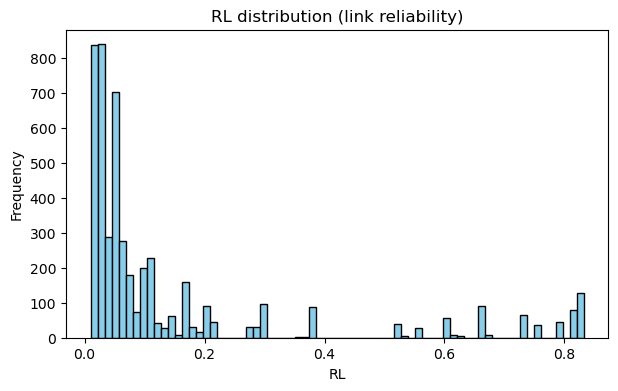

In [ ]:
### DEBUGGING
RL_values = np.array(list(RL.values()))
print(f"RL min: {RL_values.min():.4f}, RL max: {RL_values.max():.4f}, RL mean: {RL_values.mean():.4f}, RL std: {RL_values.std():.4f}")

plt.figure(figsize=(7,4))
plt.hist(RL_values, bins=70, color='skyblue', edgecolor='black')
plt.title("RL distribution (link reliability)")
plt.xlabel("RL")
plt.ylabel("Frequency")
plt.show()

After running the MCMC sampling and estimating the link reliabilities, we obtain a distribution of reliability scores for all possible node pairs in the observed network. These reliability values quantify the probability that a given link truly exists, given the observed data and the inferred block structure.

By visualizing the distribution of reliability values, we can assess how well the method distinguishes between likely and unlikely links. A broad distribution, with values close to 0 for unlikely links and close to 1 for likely links, indicates good discriminative power.

#### 2.1.1 Ranking Probability for Missing and Spurious Interactions in Networks

The following two functions are defined to evaluate the discriminative power of the link reliability (RL) scores:

- `rank_probability_missing_interactions`:  
  Computes the probability that a false negative (a missing link, i.e., a link present in the true network but absent in the observed network) has a higher RL than a true negative (a link absent in both networks).  
  A value close to 1 indicates that the method is effective at ranking missing links as more reliable than truly absent links.

- `rank_probability_spurious_interactions`:  
  Computes the probability that a false positive (a spurious link, i.e., a link present only in the observed network) has a lower RL than a true positive (a link present in both networks).  
  A value close to 1 means that spurious links are correctly assigned lower reliability than true links.

These metrics quantify how well the RL scores distinguish between true and false links, providing an interpretable measure of the method's accuracy in identifying missing and spurious interactions in network reconstruction tasks.

In [17]:
def rank_probability_missing_interactions(G_true, G_obs, RL):
    """
    Computes the probability that a false negative (AO=0, AT=1) has a higher RL
    than a true negative (AO=0, AT=0).
    
    G_true: True network (AT)
    G_obs: Observed network (AO)
    RL: Dictionary of link reliability for each pair (i, j) with i < j.
    """
    false_negatives = []  # AO=0, AT=1
    true_negatives = []   # AO=0, AT=0
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    # Build lists of node pairs based on definitions
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 0:
                if A_true[i, j] == 1:
                    false_negatives.append(RL[(i, j)])
                else:
                    true_negatives.append(RL[(i, j)])
    
    # If there are no examples, return None or 0
    if not false_negatives or not true_negatives:
        return None
    
    count = 0
    total = 0
    # For each pair, add 1 if the false negative has a higher RL than the true negative,
    # 0.5 if they are equal.
    for fn in false_negatives:
        for tn in true_negatives:
            total += 1
            if fn > tn:
                count += 1
            elif fn == tn:
                count += 0.5
    probability = count / total
    return probability


def rank_probability_spurious_interactions(G_true, G_obs, RL):
    """
    Computes the probability that a false positive (AO=1, AT=0) has a lower RL
    than a true positive (AO=1, AT=1).
    
    G_true: True network (AT)
    G_obs: Observed network (AO)
    RL: Dictionary of link reliability for each pair (i, j) with i < j.
    """
    false_positives = []  # AO=1, AT=0
    true_positives = []   # AO=1, AT=1
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 1:
                if A_true[i, j] == 0:
                    false_positives.append(RL[(i, j)])
                else:
                    true_positives.append(RL[(i, j)])
    
    if not false_positives or not true_positives:
        return None
    
    count = 0
    total = 0
    # Here we want the false positive to have a lower RL than the true positive,
    # meaning in descending order the true positive should come first.
    for fp in false_positives:
        for tp in true_positives:
            total += 1
            if fp < tp:
                count += 1
            elif fp == tp:
                count += 0.5
    probability = count / total
    return probability




In [18]:
# Compute the probability for missing interactions (false negatives)
p_missing = rank_probability_missing_interactions(G_true, G_obs, RL)
if p_missing is not None:
    print(f"Probability that a false negative has a higher RL than a true negative: {p_missing:.4f}")
else:
    print("Not enough examples for missing interactions.")
    
# Compute the probability for spurious interactions (false positives)
p_spurious = rank_probability_spurious_interactions(G_true, G_obs, RL)
if p_spurious is not None:
    print(f"Probability that a false positive has a lower RL than a true positive: {p_spurious:.4f}")
else:
    print("Not enough examples for spurious interactions.")

Probability that a false negative has a higher RL than a true negative: 0.9424
Probability that a false positive has a lower RL than a true positive: 0.9052


High values for both metrics demonstrate that the link reliability scores provide strong discrimination between true and false interactions, supporting the effectiveness of the effectiveness of the network reconstruction approach.

### 2.1.2 Autocorrelation Analysis for MCMC Samples

Let's introduce two utility functions for analyzing the autocorrelation of sampled values and for estimating the integrated autocorrelation time $\tau_{int}$ of a time series:

- `autocorrelation`:  
  Computes the autocorrelation coefficient of a given series for a specified lag. This helps to quantify how much the values in the series are correlated with their past values at a certain distance.

- `estimate_autocorrelation_time`:  
  Estimates the integrated autocorrelation time ($\tau_{int}$) of the series, which is important for assessing the statistical independence of samples obtained via MCMC. The function sums the autocorrelation coefficients up to a maximum lag or until the autocorrelation drops below a threshold.

These functions are useful for determining the appropriate thinning interval when subsampling MCMC traces, ensuring that the retained samples are approximately independent and suitable for reliable statistical analysis.

In [19]:
## The cell is used in the other cell "calculate_accuracies_and_properties"
def autocorrelation(series, lag):
    """
    Computes the autocorrelation coefficient for a given series and a specific lag.
    """
    n = len(series)
    if lag >= n:
        return 0
    series = np.array(series)
    mean = np.mean(series)
    c0 = np.sum((series - mean) ** 2) / n
    ct = np.sum((series[:n - lag] - mean) * (series[lag:] - mean)) / (n - lag)
    return ct / c0


def estimate_autocorrelation_time(series, max_lag=None, threshold=0.05):
    """
    Estimates the integrated autocorrelation time (tau_int) of the series.

    :param series: Time series (list or array) of sampled values (e.g., H(P)).
    :param max_lag: Maximum lag for which to compute the autocorrelation. If None, uses len(series)//2.
    :param threshold: Option to stop summing when the autocorrelation drops below this value.
    :return: tau_int, the integrated autocorrelation time.
    """
    n = len(series)
    if max_lag is None:
        max_lag = n // 2

    tau_int = 1.0  # includes t=0, so rho(0)=1
    acfs = [1.0]  # autocorrelation at lag 0 is 1
    for lag in range(1, max_lag):
        rho = autocorrelation(series, lag)
        acfs.append(rho)
        # If the autocorrelation is below the threshold, we can stop summing
        if rho < threshold:
            break
    # Sum the terms (multiplied by 2, as in the standard formula)
    tau_int += 2 * np.sum(acfs[1:])
    return tau_int, acfs
    

**Note:**  
The actual calculation of accuracies will be performed in a later section of the notebook.

### 2.2 Network reliability   

Here we define the function `compute_network_reliability`, which calculates the network reliability $(RN_A)$ for a candidate network $(G_{candidate})$ with respect to the observed network $( G_{obs})$, using the sampled partitions and their entropy values.

- The function iterates over all sampled partitions, grouping nodes into blocks and computing the number of possible and observed links within and between blocks for both the candidate and observed networks.
- For each partition, it calculates a likelihood-like score $( h(A; AO, P))$ using combinatorial terms, reflecting how well the candidate network fits the observed data under the block structure.
- The final network reliability $(RN_A)$ is obtained by averaging these scores over all partitions, weighted by the entropy-based importance of each partition.

This measure allows for the quantitative comparison of different network reconstructions, guiding the search for the most plausible network structure given noisy or incomplete observations.

In [20]:
def compute_network_reliability(G_candidate, G_obs, partitions, H_values):
    """
    Computes the network reliability RN_A for a candidate network G_candidate
    with respect to the observation G_obs, using the sampled partitions and H_values.
    """
    nodes = list(G_candidate.nodes())
    A = nx.to_numpy_array(G_candidate)
    AO = nx.to_numpy_array(G_obs)
    c = max(H_values)
    Z = 0.0
    RN_A = 0.0

    h_list = []
    for P, H_P in zip(partitions, H_values):
        # Group nodes by block
        block_nodes = {}
        for node, group in P.items():
            block_nodes.setdefault(group, []).append(node)
        groups = list(block_nodes.keys())

        # Precompute r, lO (on AO), l (on candidate A)
        r = {}
        lO = {}
        l = {}
        for g1 in groups:
            for g2 in groups:
                key = tuple(sorted([g1, g2]))
                if key not in r:
                    if g1 == g2:
                        n = len(block_nodes[g1])
                        r[key] = n * (n - 1) // 2
                        lO[key] = np.sum(AO[np.ix_(block_nodes[g1], block_nodes[g2])]) // 2
                        l[key] = np.sum(A[np.ix_(block_nodes[g1], block_nodes[g2])]) // 2
                    else:
                        n1 = len(block_nodes[g1])
                        n2 = len(block_nodes[g2])
                        r[key] = n1 * n2
                        lO[key] = np.sum(AO[np.ix_(block_nodes[g1], block_nodes[g2])])
                        l[key] = np.sum(A[np.ix_(block_nodes[g1], block_nodes[g2])])

        # Compute h(A; AO, P)
        h = 0.0
        for key in r:
            r_ab = r[key]
            lO_ab = int(lO[key])
            l_ab = int(l[key])
            # Combinatorial terms (use log-gamma for numerical stability)
            try:
                log_comb1 = math.lgamma(r_ab + 1) - math.lgamma(lO_ab + 1) - math.lgamma(r_ab - lO_ab + 1)
                log_comb2 = math.lgamma(2 * r_ab + 1) - math.lgamma(l_ab + lO_ab + 1) - math.lgamma(2 * r_ab - l_ab - lO_ab + 1)
            except ValueError:
                log_comb1 = 0
                log_comb2 = 0
            h += np.log((r_ab + 1) / (2 * r_ab + 1)) + (log_comb1 - log_comb2)
        h_list.append(h)

    #print(f"h_list (first 3): {h_list[:3]}")
    h_max = max(h_list)
    # Now normalized weighted sum
    for h, H_P in zip(h_list, H_values):
        weight = np.exp(-H_P + c)
        RN_A += np.exp(h - h_max) * weight
        Z += weight

    return RN_A / Z if Z > 0 else 0

### 2.3 Network Reconstruction Heuristic

This cell implements the `reconstruct_network` function, which reconstructs the network by maximizing the network reliability \( RN_A \) using a heuristic swap procedure:

- The function iteratively attempts to improve the observed network by swapping the least reliable observed edge (lowest RL) with the most reliable non-edge (highest RL).
- For each swap, it computes the network reliability of the candidate network. If the reliability increases, the swap is accepted; otherwise, it is rejected.
- The process continues until no further improvements are possible or a maximum number of consecutive rejections is reached.
- After each accepted swap, the link reliabilities are recalculated and the edge/non-edge lists are updated.

This approach aims to iteratively refine the observed network, making it more consistent with the inferred block structure and the sampled partitions, as described in the referenced paper.

In [21]:
def reconstruct_network(G_obs, partitions, H_values, RL, max_rejects=15):
    """
    Reconstructs the network AR by maximizing RN_A according to the heuristic procedure described in the paper.
    """
    G_rec = G_obs.copy()
    nodes = list(G_obs.nodes())
    # List of edges and non-edges with RL
    edges = [(i, j) for i, j in G_obs.edges() if i < j]
    non_edges = [(i, j) for i in range(len(nodes)) for j in range(i+1, len(nodes)) if not G_obs.has_edge(i, j)]
    # Sort observed edges by increasing RL (less reliable)
    edges_sorted = sorted(edges, key=lambda x: RL.get(x, 0))
    # Sort non-edges by decreasing RL (more reliable)
    non_edges_sorted = sorted(non_edges, key=lambda x: RL.get(x, 0), reverse=True)

    swap_count = 0

    while True:
        rejects = 0
        idx_edge = 0
        idx_nonedge = 0
        best_RN = compute_network_reliability(G_rec, G_obs, partitions, H_values)
        improved = False

        while rejects < max_rejects and idx_edge < len(edges_sorted) and idx_nonedge < len(non_edges_sorted):
            u, v = edges_sorted[idx_edge]
            x, y = non_edges_sorted[idx_nonedge]
            # Create a candidate copy
            G_candidate = G_rec.copy()
            G_candidate.remove_edge(u, v)
            G_candidate.add_edge(x, y)
            RN_candidate = compute_network_reliability(G_candidate, G_obs, partitions, H_values)
            # Print RN_A values (debugging)
            #print(f"RN before swap: {best_RN:.6f}, RN after swap ({u},{v}) -> ({x},{y}): {RN_candidate:.6f}")

            if RN_candidate > best_RN:
                # Accept the swap
                print(f"Swap accepted: ({u},{v}) -> ({x},{y})")
                G_rec = G_candidate
                best_RN = RN_candidate
                improved = True
                swap_count += 1
                break  # After each acceptance, recompute RL and restart
            else:
                rejects += 1
            idx_edge += 1
            idx_nonedge += 1

        if not improved:
            break  # No swap accepted, terminate
        # Recompute RL on the new G_rec (optional)
        RL = estimate_link_reliability(G_rec, partitions, H_values)
        # Update the sorted lists
        edges = [(i, j) for i, j in G_rec.edges() if i < j]
        non_edges = [(i, j) for i in range(len(nodes)) for j in range(i+1, len(nodes)) if not G_rec.has_edge(i, j)]
        edges_sorted = sorted(edges, key=lambda x: RL.get(x, 0))
        non_edges_sorted = sorted(non_edges, key=lambda x: RL.get(x, 0), reverse=True)
        print(f"edges_sorted: {len(edges_sorted)} elements, non_edges_sorted: {len(non_edges_sorted)} elements")
        if not edges_sorted:
            print("WARNING: edges_sorted is empty!")
        if not non_edges_sorted:
            print("WARNING: non_edges_sorted is empty!")

    print(f"Total number of swaps ACCEPTED: {swap_count}")
    return G_rec

In [22]:
# Reconstruct the network using the heuristic procedure
G_reconstructed = reconstruct_network(G_obs, partitions_thinned, H_final, RL)

Swap accepted: (5,72) -> (47,92)
edges_sorted: 708 elements, non_edges_sorted: 4242 elements
Swap accepted: (37,61) -> (40,99)
edges_sorted: 708 elements, non_edges_sorted: 4242 elements
Swap accepted: (25,66) -> (90,96)
edges_sorted: 708 elements, non_edges_sorted: 4242 elements
Swap accepted: (84,89) -> (96,99)
edges_sorted: 708 elements, non_edges_sorted: 4242 elements
Swap accepted: (21,42) -> (2,4)
edges_sorted: 708 elements, non_edges_sorted: 4242 elements
Swap accepted: (39,57) -> (8,55)
edges_sorted: 708 elements, non_edges_sorted: 4242 elements
Swap accepted: (45,55) -> (2,55)
edges_sorted: 708 elements, non_edges_sorted: 4242 elements
Swap accepted: (17,41) -> (53,54)
edges_sorted: 708 elements, non_edges_sorted: 4242 elements
Swap accepted: (69,81) -> (54,55)
edges_sorted: 708 elements, non_edges_sorted: 4242 elements
Swap accepted: (69,88) -> (4,51)
edges_sorted: 708 elements, non_edges_sorted: 4242 elements
Swap accepted: (4,18) -> (51,54)
edges_sorted: 708 elements, non_e

## 3 Analysis to Visualize the Results

### 3.1 Visualization and evaluation of the Reconstructed Network

This cell provides a function to visualize the reconstructed network, highlighting the differences with respect to the true network:

- **Missing links** (present in the true network but not in the reconstructed one) are shown in orange.
- **Spurious links** (present in the reconstructed network but not in the true one) are shown in blue.
- All other links (correctly reconstructed) are shown in gray.

This visualization helps to immediately identify which links have been incorrectly removed or added during the reconstruction process, and to qualitatively assess the performance of the reconstruction algorithm.

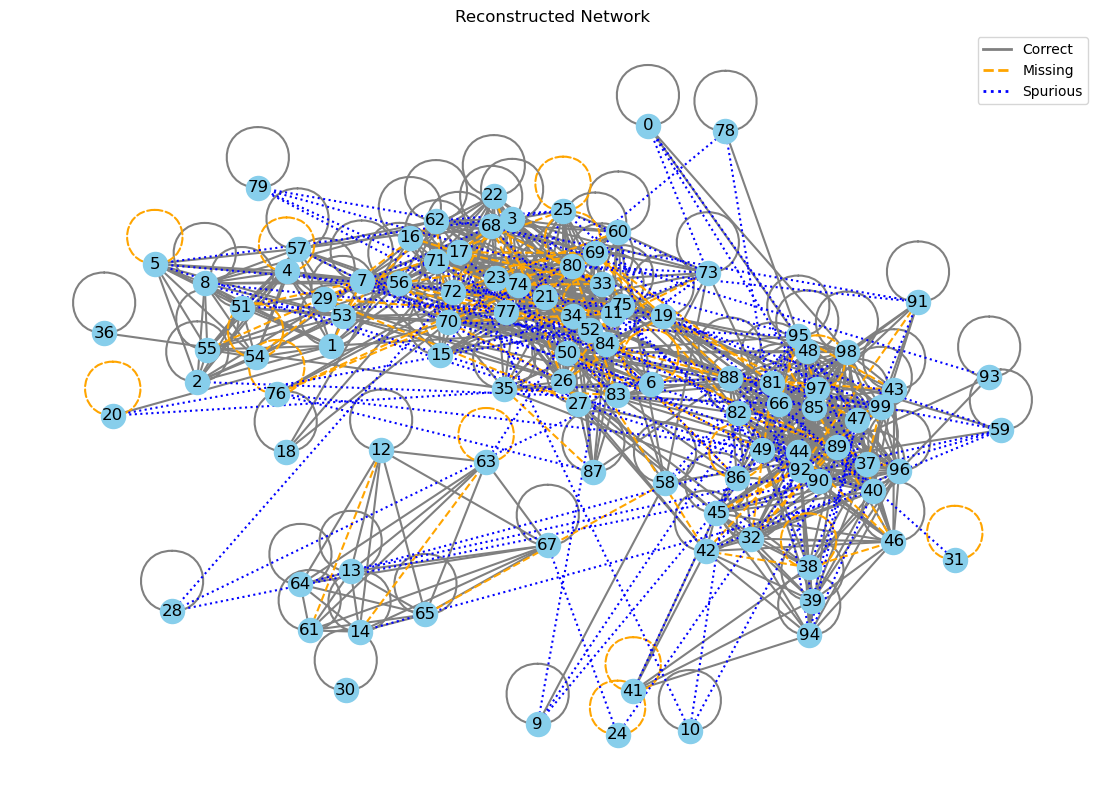

In [23]:
def plot_reconstruction_diff(G_true, G_rec, title="Reconstructed Network"):
    """
    Plots the reconstructed network highlighting:
    - missing links (present in G_true but not in G_rec) in orange
    - spurious links (present in G_rec but not in G_true) in blue
    - all other links (correctly reconstructed) in gray
    """
    pos = nx.spring_layout(G_true, k=0.7, seed=42)
    # Find missing and spurious links
    true_edges = set(tuple(sorted(e)) for e in G_true.edges())
    rec_edges = set(tuple(sorted(e)) for e in G_rec.edges())
    missing = true_edges - rec_edges
    spurious = rec_edges - true_edges
    common = true_edges & rec_edges

    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G_true, pos, node_color='skyblue', node_size=300)
    nx.draw_networkx_labels(G_true, pos, font_color='black')

    # Common edges in gray
    nx.draw_networkx_edges(G_true, pos, edgelist=list(common), edge_color='gray', width=1.5)
    # Missing in orange
    nx.draw_networkx_edges(G_true, pos, edgelist=list(missing), edge_color='orange', width=1.5, style='dashed', label='Missing')
    # Spurious in blue
    nx.draw_networkx_edges(G_true, pos, edgelist=list(spurious), edge_color='blue', width=1.5, style='dotted', label='Spurious')

    plt.title(title)
    plt.axis('off')
    plt.legend(handles=[
        plt.Line2D([0], [0], color='gray', lw=2, label='Correct'),
        plt.Line2D([0], [0], color='orange', lw=2, linestyle='--', label='Missing'),
        plt.Line2D([0], [0], color='blue', lw=2, linestyle=':', label='Spurious')
    ])
    plt.show()

# Plot the reconstructed network
plot_reconstruction_diff(G_true, G_reconstructed)

This cell defines and demonstrates the `reconstruction_error_metrics` function, which quantitatively evaluates the quality of the reconstructed network compared to both the true and observed networks. The function computes:

- **Missing links**: Edges present in the true network but absent in the observed or reconstructed network.
- **Spurious links**: Edges present in the observed or reconstructed network but absent in the true network.
- **Percentage improvement**: The relative reduction in missing and spurious links in the reconstructed network compared to the observed network.

The function returns a dictionary with the counts of missing and spurious links for both the observed and reconstructed networks, as well as the percentage improvements. This allows for a direct and interpretable assessment of how much the reconstruction process has improved the network structure with respect to the ground truth.


In [24]:
def reconstruction_error_metrics(G_true, G_obs, G_rec):
    """
    Computes the number of missing and spurious links for G_obs and G_rec,
    and the percentage improvement of the reconstruction compared to the observation.
    """
    # Set of edges (undirected)
    true_edges = set(tuple(sorted(e)) for e in G_true.edges())
    obs_edges = set(tuple(sorted(e)) for e in G_obs.edges())
    rec_edges = set(tuple(sorted(e)) for e in G_rec.edges())

    # Missing: present in G_true but not in G_X
    missing_obs = true_edges - obs_edges
    missing_rec = true_edges - rec_edges

    # Spurious: present in G_X but not in G_true
    spurious_obs = obs_edges - true_edges
    spurious_rec = rec_edges - true_edges

    # Percentage improvement
    perc_impr_missing = 100 * (len(missing_obs) - len(missing_rec)) / len(missing_obs) if len(missing_obs) > 0 else 0
    perc_impr_spurious = 100 * (len(spurious_obs) - len(spurious_rec)) / len(spurious_obs) if len(spurious_obs) > 0 else 0

    results = {
        "missing_obs": len(missing_obs),
        "missing_rec": len(missing_rec),
        "spurious_obs": len(spurious_obs),
        "spurious_rec": len(spurious_rec),
        "perc_impr_missing": perc_impr_missing,
        "perc_impr_spurious": perc_impr_spurious
    }
    return results

# Compute and print the reconstruction error metrics
metrics = reconstruction_error_metrics(G_true, G_obs, G_reconstructed)
print(f"Missing links - Observed: {metrics['missing_obs']}, Reconstructed: {metrics['missing_rec']} ({metrics['perc_impr_missing']:.1f}% improvement)")
print(f"Spurious links - Observed: {metrics['spurious_obs']}, Reconstructed: {metrics['spurious_rec']} ({metrics['perc_impr_spurious']:.1f}% improvement)")

Missing links - Observed: 113, Reconstructed: 94 (16.8% improvement)
Spurious links - Observed: 100, Reconstructed: 81 (19.0% improvement)


This cell defines and uses the `percent_difference_edges` function to quantify the structural difference between two networks.  
Specifically, it computes the percentage of edges that are different (either missing or spurious) between the true network and another network (either the observed or reconstructed network).  
This metric provides a simple way to assess how much the observed or reconstructed network deviates from the ground truth in terms of edge presence, summarizing both types of errors in a single percentage value.

In [ ]:
# Just for checking the percentage of edges that are different between the true network and the reconstructed network
def percent_difference_edges(G_true, G_rec):
    """
    Calculates the percentage of edges that are different between the true network and the reconstructed network.
    """
    true_edges = set(tuple(sorted(e)) for e in G_true.edges())
    rec_edges = set(tuple(sorted(e)) for e in G_rec.edges())
    # Different edges: present only in one of the two networks
    diff_edges = true_edges.symmetric_difference(rec_edges)
    # Percentage with respect to the number of edges in the true network
    perc_diff = 100 * len(diff_edges) / len(true_edges) if len(true_edges) > 0 else 0
    print(f"Different edges (missing + spurious): {len(diff_edges)} out of {len(true_edges)} true edges ({perc_diff:.1f}%)")
    return perc_diff


print("Difference between true network and observed network:")
percent_difference_edges(G_true, G_obs)

print("Difference between true network and reconstructed network:")
percent_difference_edges(G_true, G_reconstructed)

Difference between true network and observed network:
Different edges (missing + spurious): 213 out of 805 true edges (26.5%)
Difference between true network and reconstructed network:
Different edges (missing + spurious): 175 out of 805 true edges (21.7%)


21.73913043478261

### 3.2 Network Accuracies and Properties

Now, the function `network_properties` computes several key network properties required by the referenced paper.  
The function calculates the average clustering coefficient, modularity (using the Louvain method or a greedy algorithm as a fallback), degree assortativity, maximum betweenness centrality, synchronizability (ratio of Laplacian eigenvalues), and the spreading threshold (ratio of degree moments).  
These metrics are used to quantitatively compare the structural characteristics of the true, observed, and reconstructed networks.

In [26]:
def network_properties(G):
    """
    Computes the network properties required by the paper:
    - average clustering coefficient
    - modularity (using the Louvain partition)
    - assortativity
    - maximum betweenness centrality (congestability)
    - synchronizability (ratio between Laplacian eigenvalues)
    - spreading threshold (ratio between degree moments)
    """
    try:
        import community as community_louvain  
    except ImportError:
        community_louvain = None

    props = {}

    # Average clustering coefficient
    props['clustering'] = nx.average_clustering(G)

    # Modularity (Louvain)
    if community_louvain is not None:
        partition = community_louvain.best_partition(G)
        modularity = community_louvain.modularity(partition, G)
    else:
        # Fallback: modularity with greedy_modularity_communities
        from networkx.algorithms.community import greedy_modularity_communities
        comms = list(greedy_modularity_communities(G))
        modularity = nx.algorithms.community.quality.modularity(G, comms)
    props['modularity'] = modularity

    # Assortativity
    props['assortativity'] = nx.degree_assortativity_coefficient(G)

    # Maximum betweenness centrality (congestability)
    betw = nx.betweenness_centrality(G)
    props['max_betweenness'] = max(betw.values()) if betw else 0

    # Synchronizability: ratio between the largest and smallest nonzero Laplacian eigenvalue
    L = nx.laplacian_matrix(G).todense()
    eigvals = np.linalg.eigvalsh(L)
    eigvals = np.sort(np.real(eigvals))
    # Take the largest and the smallest >0
    if len(eigvals) > 2:
        lambda_max = eigvals[-1]
        lambda_min = eigvals[1]  # the first is always zero
        props['synchronizability'] = lambda_max / lambda_min if lambda_min > 0 else np.nan
    else:
        props['synchronizability'] = np.nan

    # Spreading threshold: ratio between first and second moment of degrees
    degrees = np.array([d for n, d in G.degree()])
    k1 = np.mean(degrees)
    k2 = np.mean(degrees ** 2)
    props['spreading_threshold'] = k1 / (k2 - k1) if (k2 - k1) != 0 else np.nan

    return props

The function `calculate_accuracies_and_properties` systematically evaluates the impact of observation errors on network reconstruction. For each specified error fraction, it:

- Generates an observed network by introducing random errors into the true network.
- Performs MCMC sampling to obtain network partitions and applies thinning to ensure sample independence.
- Estimates link reliabilities and reconstructs the network using a heuristic based on these reliabilities.
- Computes key network properties (clustering, modularity, assortativity, maximum betweenness, synchronizability, and spreading threshold) for the true, observed, and reconstructed networks.
- Calculates the relative error for each property and the accuracy in identifying missing and spurious interactions.
- Aggregates results over multiple repetitions for statistical robustness.

The function returns the relative errors and accuracies for all error fractions, enabling quantitative comparison of network reconstruction performance as observation noise increases.

In [27]:
def calculate_accuracies_and_properties(
    G_true, 
    error_fractions, 
    num_samples, 
    equilibration, 
    n_repeats, 
    thinning_auto, 
    thinning_interval
):
    """
    Computes accuracies (missing/spurious) and network property statistics
    for each error fraction, with n_repeats repetitions for statistical robustness.
    """
    prop_names = [
        'clustering', 'modularity', 'assortativity', 
        'max_betweenness', 'synchronizability', 'spreading_threshold'
    ]
    relerr_obs_all = {p: [] for p in prop_names}
    relerr_rec_all = {p: [] for p in prop_names}
    accuracy_missing = []
    accuracy_spurious = []

    for f in error_fractions:
        relerr_obs_rep = {p: [] for p in prop_names}
        relerr_rec_rep = {p: [] for p in prop_names}
        acc_missing_rep = []
        acc_spurious_rep = []
        for rep in range(n_repeats):
            # 1. Generate observed network with error fraction f
            G_obs, _, _ = modify_network(G_true, f)
            # 2. Run MCMC on G_obs
            partitions, _, H_full_trace = mcmc_trace_H(G_obs, equilibration=equilibration, num_samples=num_samples)
            if thinning_auto:
                thinning = max(1, int(estimate_autocorrelation_time(H_full_trace)[0]))
            else:
                thinning = thinning_interval
            H_final = H_full_trace[::thinning]
            partitions_thinned = partitions[::thinning]
            RL = estimate_link_reliability(G_obs, partitions_thinned, H_final)
            # 3. Reconstruct the network
            G_rec = reconstruct_network(G_obs, partitions_thinned, H_final, RL, max_rejects=5)
            # 4. Compute network properties
            props_true = network_properties(G_true)
            props_obs = network_properties(G_obs)
            props_rec = network_properties(G_rec)
            # 5. Compute relative error for each property
            for p in prop_names:
                relerr_obs_rep[p].append((props_obs[p] - props_true[p]) / props_true[p] if props_true[p] != 0 else np.nan)
                relerr_rec_rep[p].append((props_rec[p] - props_true[p]) / props_true[p] if props_true[p] != 0 else np.nan)
            # 6. Compute accuracies
            p_missing = rank_probability_missing_interactions(G_true, G_obs, RL)
            p_spurious = rank_probability_spurious_interactions(G_true, G_obs, RL)
            acc_missing_rep.append(1.0 if p_missing is None else p_missing)
            acc_spurious_rep.append(1.0 if p_spurious is None else p_spurious)
        # 7. Save mean and std for each property
        for p in prop_names:
            relerr_obs_all[p].append((np.nanmean(relerr_obs_rep[p]), np.nanstd(relerr_obs_rep[p])))
            relerr_rec_all[p].append((np.nanmean(relerr_rec_rep[p]), np.nanstd(relerr_rec_rep[p])))
        # 8. Save mean accuracies
        accuracy_missing.append((np.mean(acc_missing_rep), np.std(acc_missing_rep)))
        accuracy_spurious.append((np.mean(acc_spurious_rep), np.std(acc_spurious_rep)))

    return relerr_obs_all, relerr_rec_all, accuracy_missing, accuracy_spurious

Runs the full analysis pipeline to evaluate the effect of observation errors on network reconstruction.  
For each error fraction, the code:

- Generates observed networks with increasing error rates.
- Computes link reliability and reconstructs the network using the proposed method.
- Calculates the accuracy in identifying missing and spurious interactions.
- Computes the relative error for key network properties (clustering, modularity, assortativity, maximum betweenness, and spreading threshold) for both the observed and reconstructed networks.
- Plots the accuracy curves and the relative errors as a function of the observation error rate.

This analysis allows for a quantitative comparison of the reconstruction performance as the level of noise in the observed network increases.

Swap accepted: (5,35) -> (2,56)
edges_sorted: 705 elements, non_edges_sorted: 4245 elements
Total number of swaps ACCEPTED: 1


C:\Users\eugen\AppData\Local\Temp\ipykernel_11064\45757722.py:57: RuntimeWarning: Mean of empty slice
  relerr_obs_all[p].append((np.nanmean(relerr_obs_rep[p]), np.nanstd(relerr_obs_rep[p])))
c:\Users\eugen\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\eugen\AppData\Local\Temp\ipykernel_11064\45757722.py:58: RuntimeWarning: Mean of empty slice
  relerr_rec_all[p].append((np.nanmean(relerr_rec_rep[p]), np.nanstd(relerr_rec_rep[p])))


Swap accepted: (1,95) -> (2,56)
edges_sorted: 704 elements, non_edges_sorted: 4246 elements
Swap accepted: (57,95) -> (53,56)
edges_sorted: 704 elements, non_edges_sorted: 4246 elements
Swap accepted: (23,76) -> (32,43)
edges_sorted: 704 elements, non_edges_sorted: 4246 elements
Swap accepted: (13,90) -> (32,95)
edges_sorted: 704 elements, non_edges_sorted: 4246 elements
Swap accepted: (13,96) -> (32,48)
edges_sorted: 704 elements, non_edges_sorted: 4246 elements
Swap accepted: (59,96) -> (32,99)
edges_sorted: 704 elements, non_edges_sorted: 4246 elements
Swap accepted: (61,69) -> (40,95)
edges_sorted: 704 elements, non_edges_sorted: 4246 elements
Total number of swaps ACCEPTED: 7
Swap accepted: (10,48) -> (43,49)
edges_sorted: 702 elements, non_edges_sorted: 4248 elements
Swap accepted: (78,95) -> (43,81)
edges_sorted: 702 elements, non_edges_sorted: 4248 elements
Swap accepted: (21,64) -> (43,82)
edges_sorted: 702 elements, non_edges_sorted: 4248 elements
Swap accepted: (12,44) -> (4

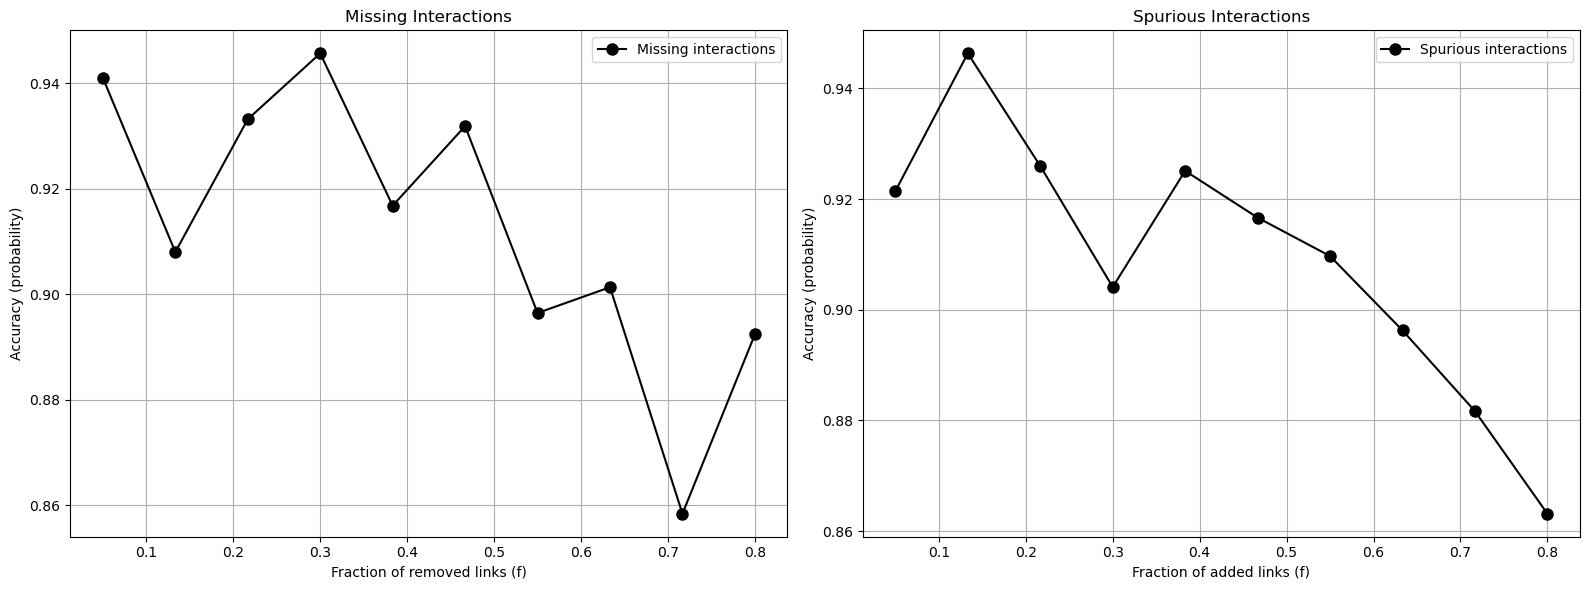

C:\Users\eugen\AppData\Local\Temp\ipykernel_11064\403686733.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ws-" (-> color='w'). The keyword argument will take precedence.
  axs[idx].errorbar(error_fractions, rec_means, yerr=rec_stds, fmt='ws-', markeredgecolor='black',color='black',markerfacecolor='white', label='Reconstruction')


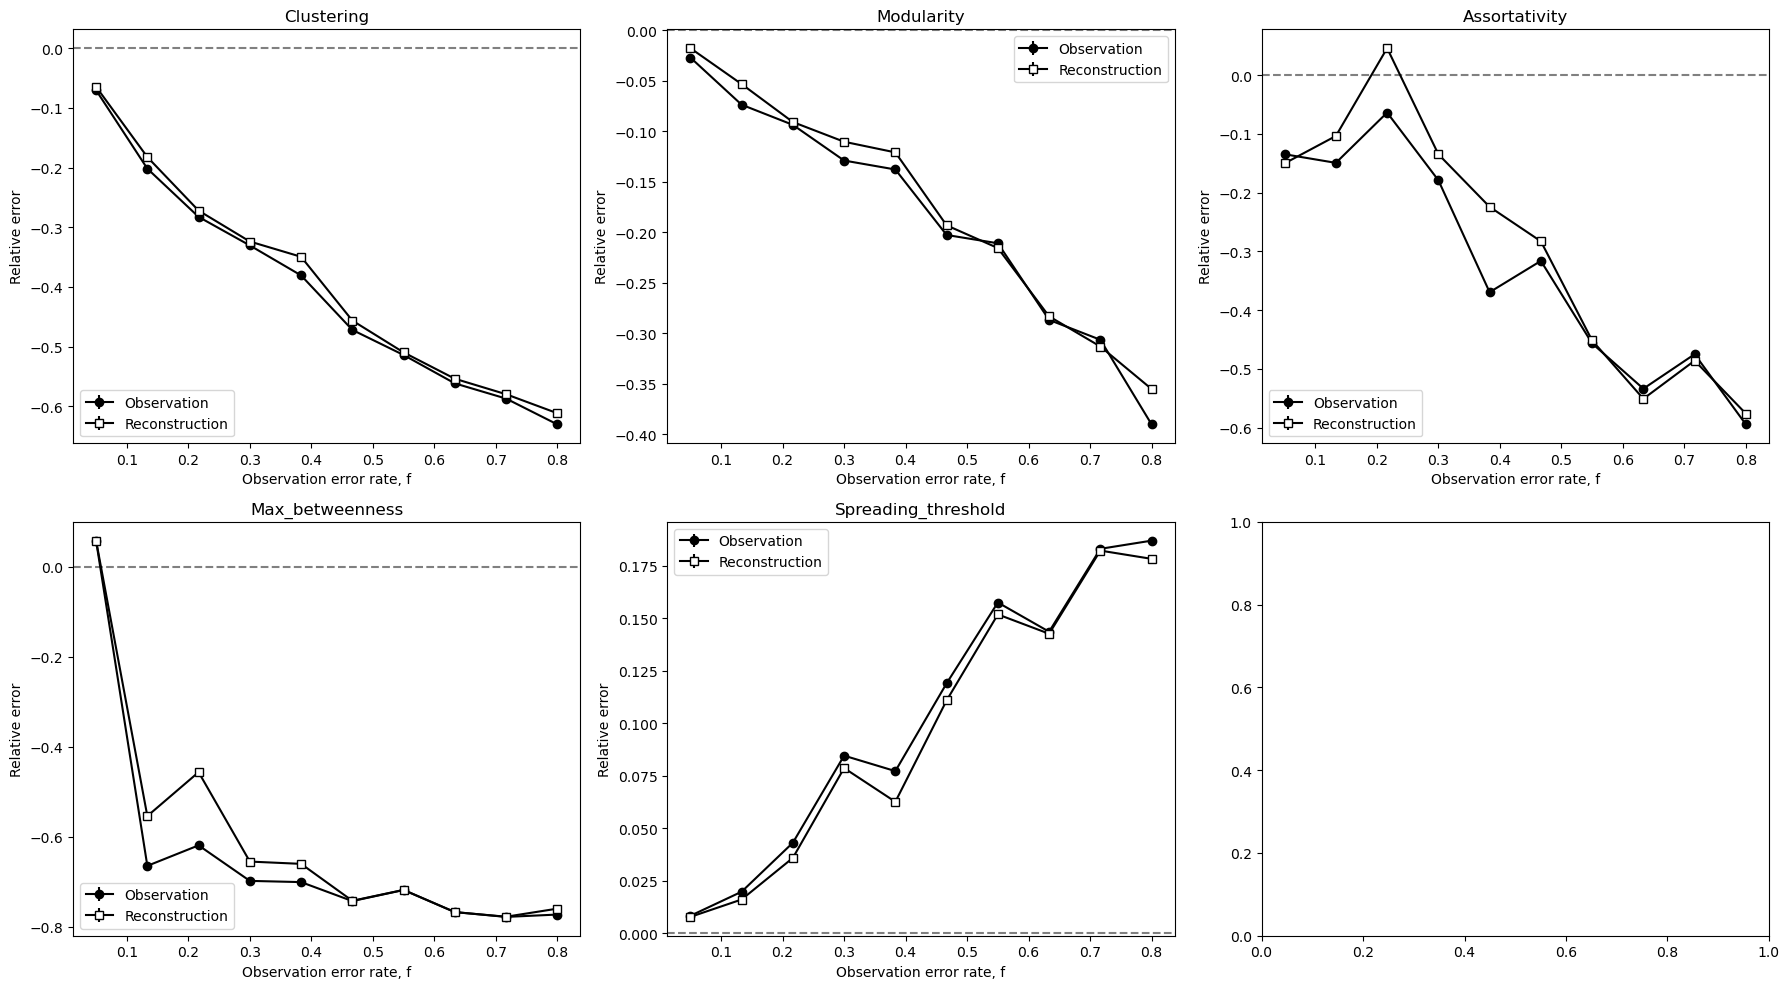

In [28]:
run_full_analysis = True  # Set to True to run the full analysis, or False to skip

if run_full_analysis:
    # # Parameters for the analysis
    error_fractions = np.linspace(0.05, 0.8, 10)  
    n_repeats = 1  # Set to 25 for averaging/statistics
    num_samples = 100000
    equilibration = 50000

    # Run the main analysis function
    relerr_obs_all, relerr_rec_all, accuracy_missing, accuracy_spurious = calculate_accuracies_and_properties(
        G_true,
        error_fractions,
        num_samples=num_samples,
        equilibration=equilibration,
        n_repeats=n_repeats,
        thinning_auto=False,         # Set to True for automatic thinning
        thinning_interval=200        # Used if thinning_auto is False
    )

    # --- Plot accuracies for missing and spurious interactions ---
    acc_missing_means = [x[0] for x in accuracy_missing]
    acc_spurious_means = [x[0] for x in accuracy_spurious]

    plot_interaction_accuracies(error_fractions, acc_missing_means, acc_spurious_means)
    #plot_interaction_accuracies(error_fractions, accuracy_missing, accuracy_spurious)

    # --- Plot relative errors of network properties ---
    prop_names = ['clustering', 'modularity', 'assortativity', 'max_betweenness', 'spreading_threshold']   ### 'synchronizability' removed 
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()
    for idx, p in enumerate(prop_names):
        obs_means = [relerr_obs_all[p][i][0] for i in range(len(error_fractions))]
        obs_stds  = [relerr_obs_all[p][i][1] for i in range(len(error_fractions))]
        rec_means = [relerr_rec_all[p][i][0] for i in range(len(error_fractions))]
        rec_stds  = [relerr_rec_all[p][i][1] for i in range(len(error_fractions))]
        axs[idx].errorbar(error_fractions, obs_means, yerr=obs_stds, fmt='ko-', label='Observation')
        axs[idx].errorbar(error_fractions, rec_means, yerr=rec_stds, fmt='ws-', markeredgecolor='black',color='black',markerfacecolor='white', label='Reconstruction')
        axs[idx].axhline(0, color='gray', linestyle='--')
        axs[idx].set_title(p.capitalize())
        axs[idx].set_xlabel('Observation error rate, f')
        axs[idx].set_ylabel('Relative error')
        axs[idx].legend()
    plt.tight_layout()
    plt.show()

Our approach is remarkably able to identify that AT is a more likely network than the observation AO itself. This confirms that, even without knowing A T , it is possible to estimate a property X (AT ) better than just by measuring that property on AO (that is, better than assuming X (AT ) = X (AO)).

The results obtained demonstrate that:

- It is possible to accurately estimate the probability of existence of a link (*link reliability*) from a noisy network observation.
- The reconstructed network improves the estimation of global network properties such as modularity, clustering coefficient, assortativity, centrality measures, and epidemic thresholds, when compared to the observed network.

These findings are consistent with those reported in the original paper, where the authors show that network reconstruction systematically yields better estimates of the true underlying network, even when up to 20% of the links are missing or spurious.

In particular, as shown also in our case, the reconstructed network:
- Reduces the number of false positive and false negative interactions compared to the observed network;
- Provides a more reliable representation of the underlying structure;
- Enables better inference of both topological and dynamical network properties.

In conclusion, the proposed framework is robust, generalizable, and practical for applications where observational noise is a concern, social networks, or infrastructure systems.
Further improvements could include more advanced sampling techniques, alternative reconstruction heuristics, and a deeper exploration of model assumptions and their limitations.
